* Test if effects of Coriolis in northward freshwater flux is inhibited by northward wind and by length of transect.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [11]:
transects = {'1':{'jst':55, 'ist':1,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '5':{'jst':120, 'ist':138,'jen':121,'ien':139}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

In [4]:
## mask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

(48.8, 49.7)

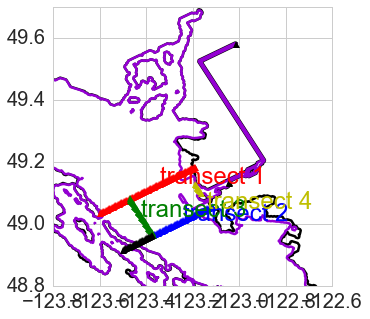

In [12]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.plot(X[55,0:80],Y[55,0:80],'r^')
ax.plot(X[25,25:75],Y[25,25:75],'b^')
ax.plot(X[25:56,25],Y[25:56,25],'g^')
ax.plot(X[37:45,72],Y[37:45,72],'y^')
ax.plot(X[34:36,94],Y[34:36,94],'k^')
ax.plot(X[25,0:25],Y[25,0:25],'k^')
ax.plot(X[120:121,155],Y[120:121,155],'k^')
ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
ax.annotate ('transect 2',(X[25,50],Y[25,50]), xycoords="data",color = 'b')
ax.annotate ('transect 3',(X[40,25],Y[40,25]), xycoords="data",color = 'g')
ax.annotate ('transect 4',(X[25,70],Y[25,70]), xycoords="data",color = 'y')
ax.set_xlim([-123.8,-122.6])
ax.set_ylim([48.8,49.7])

In [6]:
## load salinity into a dict
pathsoct = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
pathsmay = ['May2015OnlyRiver','May2015notides','May2015nowind','May2015nof','May2015combineall']
pathsjan = ['Jan2016OnlyRiver','Jan2016notides','Jan2016nowind','Jan2016nof','Jan2016combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternTs = ['oct2014*_T.nc','may2015*_T.nc','jan2016*_T.nc']
file_patternUs = ['oct2014*_U.nc','may2015*_U.nc','jan2016*_U.nc']
file_patternVs = ['oct2014*_V.nc','may2015*_V.nc','jan2016*_V.nc']
U = {}; V={}; S={};ssh = {}
paths = [pathsoct,pathsmay,pathsjan]
for paa,Tfile, Ufile,Vfile in zip(paths,file_patternTs,file_patternUs,file_patternVs):
    for pa in paa:
        pathT = glob(os.path.join(base,pa, Tfile))
        pathU = glob(os.path.join(base,pa, Ufile))
        pathV = glob(os.path.join(base,pa, Vfile))
        fU = nc.Dataset(pathU[0],'r');
        U[pa] = fU.variables['vozocrtx']
        fV = nc.Dataset(pathV[0],'r');
        V[pa] = fV.variables['vomecrty']
        fT = nc.Dataset(pathT[0],'r');
        S[pa] = fT.variables['vosaline']
        lon = fT.variables['nav_lon'] 
        lat = fT.variables['nav_lat']
        ssh[pa] = fT.variables['sossheig']
        time_counter = fT.variables['time_counter']
        depT = fT.variables['deptht']

In [7]:
def transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,t_st,t_en,paths,fresh_flag = False,\
                                y0lim =6e5, y1lim = 6000):
    """to calculate the total transport (False)or fresh water transport (True) in the entire water column 
    with focus on a continous time period rather than a specific time"""
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst']-1,transects[tran]['jen'])
    iinds = np.arange(transects[tran]['ist']-1,transects[tran]['ien'])
    for pa in paths:
        SS[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0],iinds.shape[0]])
        UU[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        VV[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        for t in np.arange(t_st[pa],t_en[pa]+1):
            SS[pa][t] = S[pa][t,:,jinds,iinds]    
            mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
            SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask 
                    
                               
            UU[pa][t],VV[pa][t] = viz_tools.unstagger(U[pa][t,:,jinds,iinds],\
                                      V[pa][t,:,jinds,iinds])
    trans,trans_sur,trans_to = transport_time_general(SS,UU,VV,ssh,lon,lat,depT,tran,t_st,t_en,\
                                                 paths,fresh_flag = fresh_flag) ## get surface/total transport
        ## location
    return trans,trans_sur,trans_to

In [8]:
def transport_time_general(S,U,V,ssh,lon,lat,depT,tran,t_st,t_en,paths,fresh_flag = False):
    """This function was made to calculate total 
    transport/fresh water transport during a continuous 
    period, rather than the specific time """
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4' or tran =='5': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([time_counter.shape[0],depT.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']).shape[0]])
            for t in np.arange(t_st[pa],t_en[pa]+1):
                for z in np.arange(depT.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                        d = e2t[j+transects[tran]['jst'],transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,j+1,1])/30
                        adj_ssh = 1+ssh[pa][t,j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3t[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*tmask[:,j+transects[tran]['jst'],transects[tran]['ist']])

                        trans[pa][t,z,j] = U[pa][t,z,j,0]*d*e3t[z,j+transects[tran]['jst']+1,transects[tran]['ist']+1]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa]= np.zeros([time_counter.shape[0],depT.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']).shape[0]]);
            for t in np.arange(t_st[pa],t_en[pa]+1):
                for z in np.arange(depT.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        d = e1t[transects[tran]['jst'],i+transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,1,i+1])/30

                        adj_ssh = 1+ssh[pa][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3t[:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[:,transects[tran]['jst'],i+transects[tran]['ist']])

                        trans[pa][t,z,i] = V[pa][t,z,0,i]*d*e3t[z,transects[tran]['jst']+1,i+transects[tran]['ist']+1]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = np.nansum(trans[pa][t_st[pa]:t_en[pa]+1,0,:],axis = 1)
        trans_total[pa] = np.nansum(np.nansum(trans[pa][t_st[pa]:t_en[pa]+1],axis = 1),axis = 1)
 
    return trans, trans_surf,trans_total

In [9]:
def plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,dep,tran,tst,ten,paths,fresh_flag = 'fresh'):
    """This function is the same with plot_series_transport, except 
    that this is not integral over several days, but only for daily case, over selected depths"""
    trans,trans_surf,trans_to = transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,tst,ten,\
                                                                 paths,fresh_flag = fresh_flag)
    inte_trans = {}; 
    for ty in paths:
        inte_trans[ty] = np.zeros((ten[ty]-tst[ty]+1)/24)
        for i in np.arange(tst[ty],ten[ty]+1,24): ## intergral individual daily
            inte_trans[ty][i/24-tst[ty]/24] = np.nansum(trans[ty][i:i+24,depT[0]:depT[dep]+1])*3600
    fig, axs = plt.subplots(2,1,figsize = (20,9))
    ax = axs[0] ## ssh
    for ty in paths:
        ax.plot(ssh[ty][tst[ty]:ten[ty]+1,86,89],label = ty)
    ax.set_ylabel('ssh at PA [m]')
    ax.set_xlabel('hour')
    ax = axs[1] ## total volumn flux,salt flux and freshwater flux for selected run case
    for ty in paths:
        ax.plot(inte_trans[ty],'o',label = ty,markersize = 10)
        if fresh_flag == 'fresh':
            ax.set_ylabel('fresh water flux $m^3$')
        else:
            ax.set_ylabel('flux $m^3$')
        ax.set_xlim([-1,(ten[ty]+1-tst[ty])/24])
    ax.legend(loc = 'best')
    ax.set_xlabel('Day')
    return inte_trans

# Three wind events in three months, respectively.

* Jan

420.77550056329306

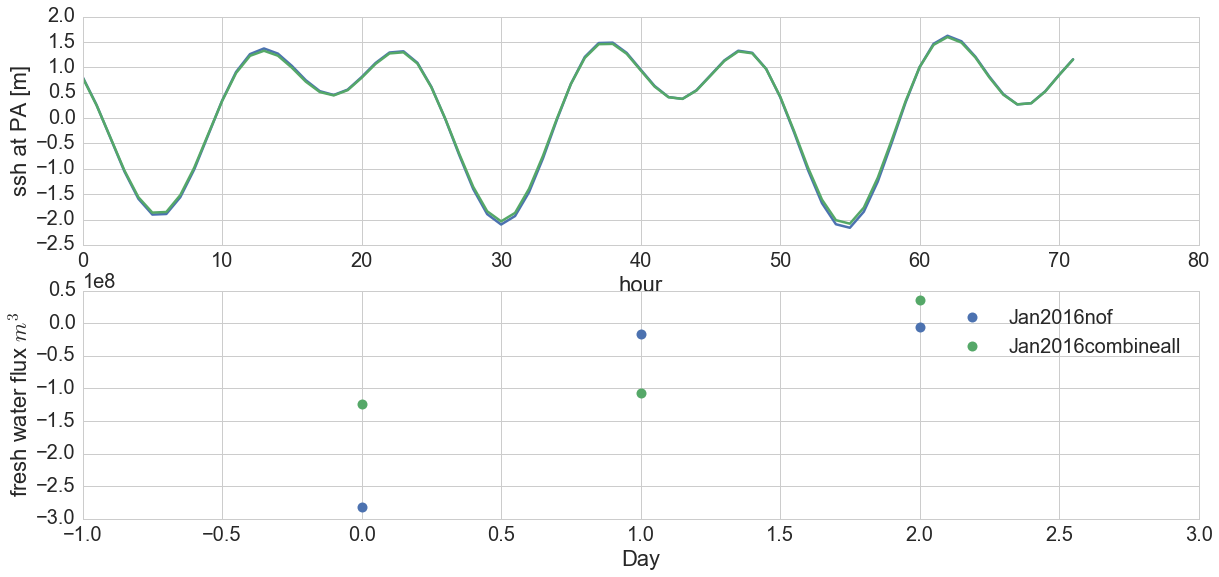

In [14]:
## weak wind Jan nof vs f
paths = ['Jan2016nof','Jan2016combineall']
tst = {'Jan2016nof':168,'Jan2016combineall':168}
ten = {'Jan2016nof':239,'Jan2016combineall':239}
jan_weak_f = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(jan_weak_f['Jan2016combineall'].sum() - jan_weak_f['Jan2016nof'].sum())/(3*24*3600)

-1694.622504668268

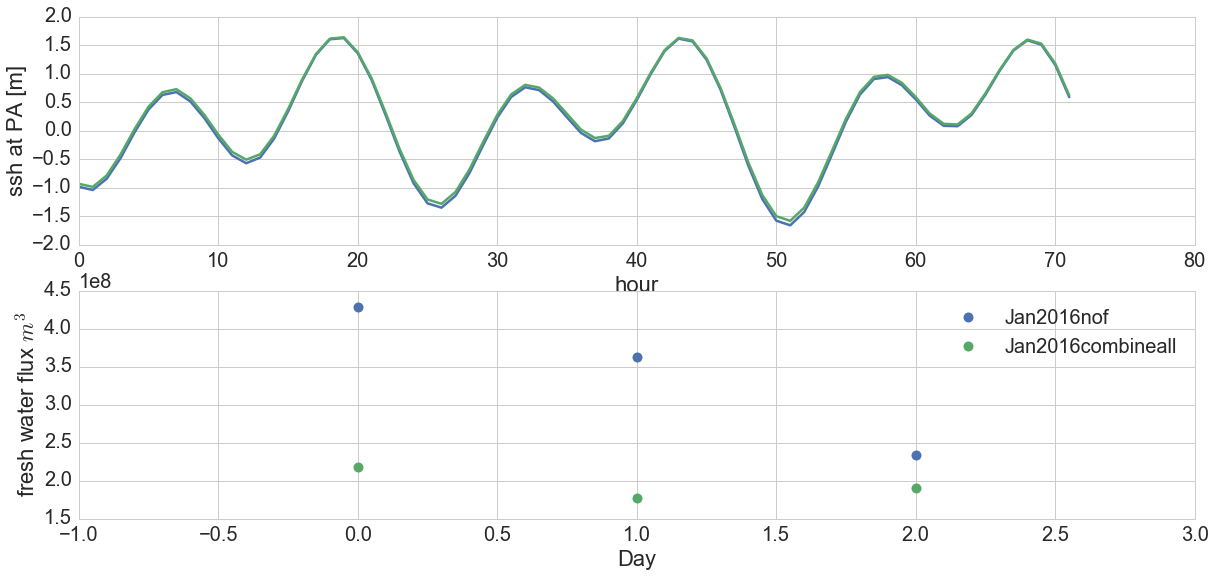

In [15]:
## moderate NW wind Jan nof vs f 
paths = ['Jan2016nof','Jan2016combineall']
tst = {'Jan2016nof':384,'Jan2016combineall':384}
ten = {'Jan2016nof':455,'Jan2016combineall':455}
inte_jan_NW_fnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_jan_NW_fnof['Jan2016combineall'].sum() - inte_jan_NW_fnof['Jan2016nof'].sum())/(24*3*3600)

-2519.0714909445996

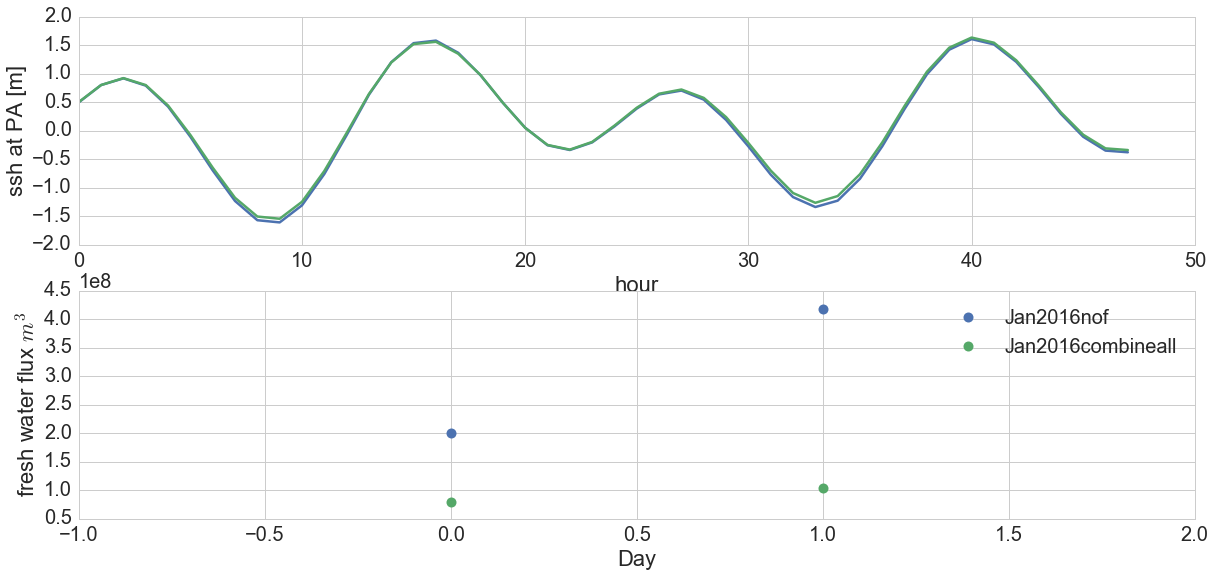

In [16]:
## strong wind Jan nof vs f
paths = ['Jan2016nof','Jan2016combineall']
tst = {'Jan2016nof':624,'Jan2016combineall':624}
ten = {'Jan2016nof':671,'Jan2016combineall':671}
inte_trans_jan_strong_NWfnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans_jan_strong_NWfnof['Jan2016combineall'].sum() - inte_trans_jan_strong_NWfnof['Jan2016nof'].sum())/(2*24*3600)

* Oct

130.05659708066912

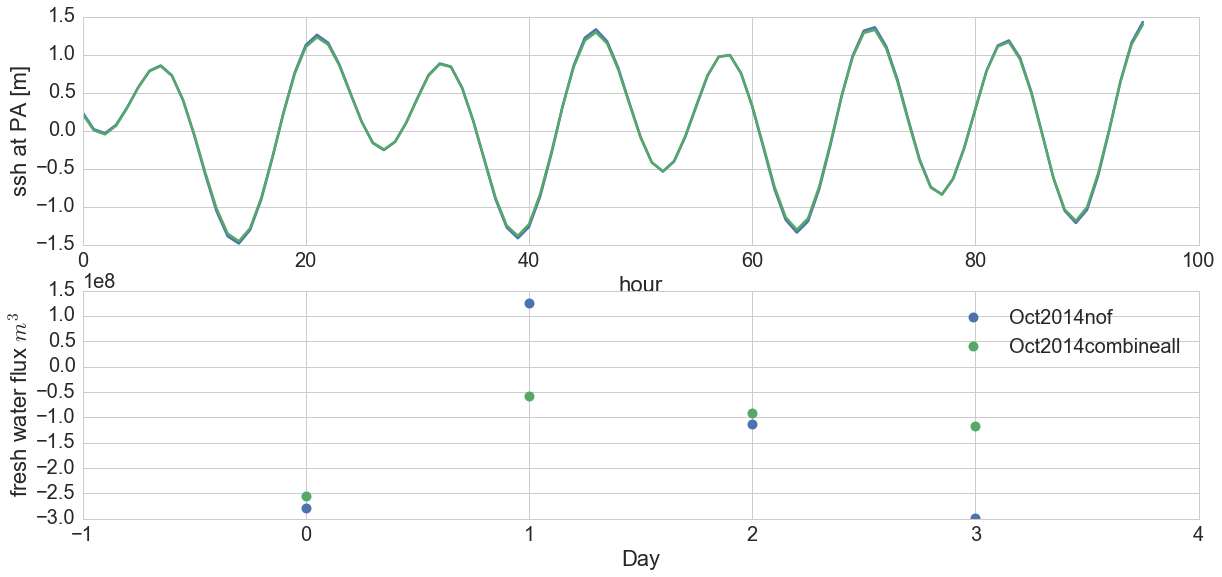

In [13]:
## weak wind october nof vs f
paths = ['Oct2014nof','Oct2014combineall']
tst = {'Oct2014nof':48,'Oct2014combineall':48}
ten = {'Oct2014nof':143,'Oct2014combineall':143}
inte_trans = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans['Oct2014combineall'].sum() - inte_trans['Oct2014nof'].sum())/(4*24*3600)

-943.87506043993301

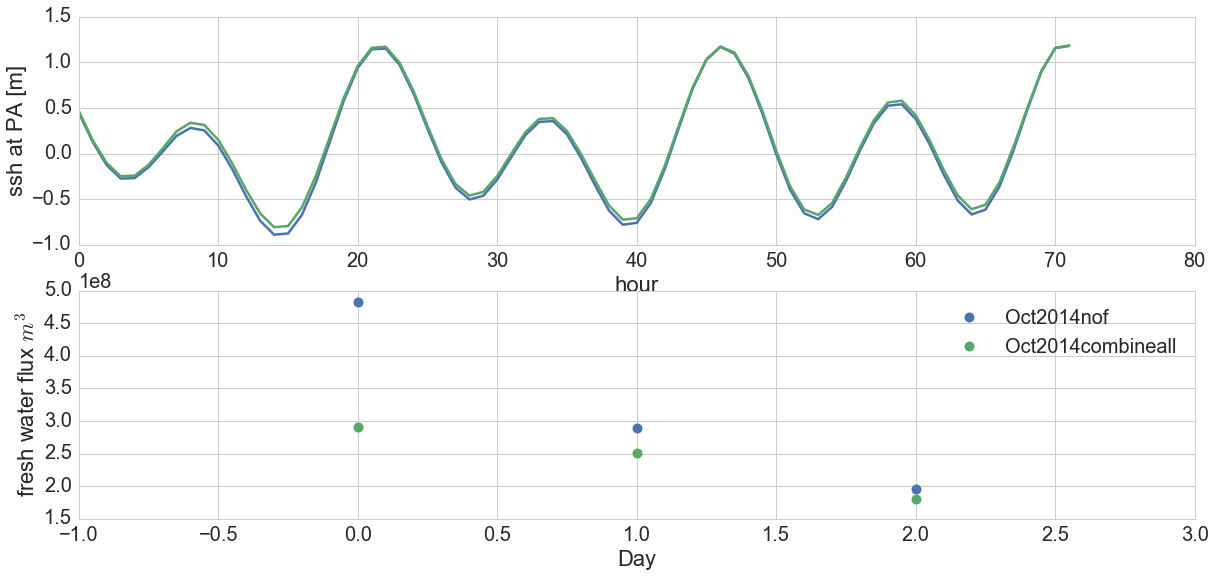

In [17]:
## moderate wind October f vs nof
paths = ['Oct2014nof','Oct2014combineall']
tst = {'Oct2014nof':408,'Oct2014combineall':408}
ten = {'Oct2014nof':479,'Oct2014combineall':479}
inte_transfnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_transfnof['Oct2014combineall'].sum() - inte_transfnof['Oct2014nof'].sum())/(24*3*3600)

708336768.95804

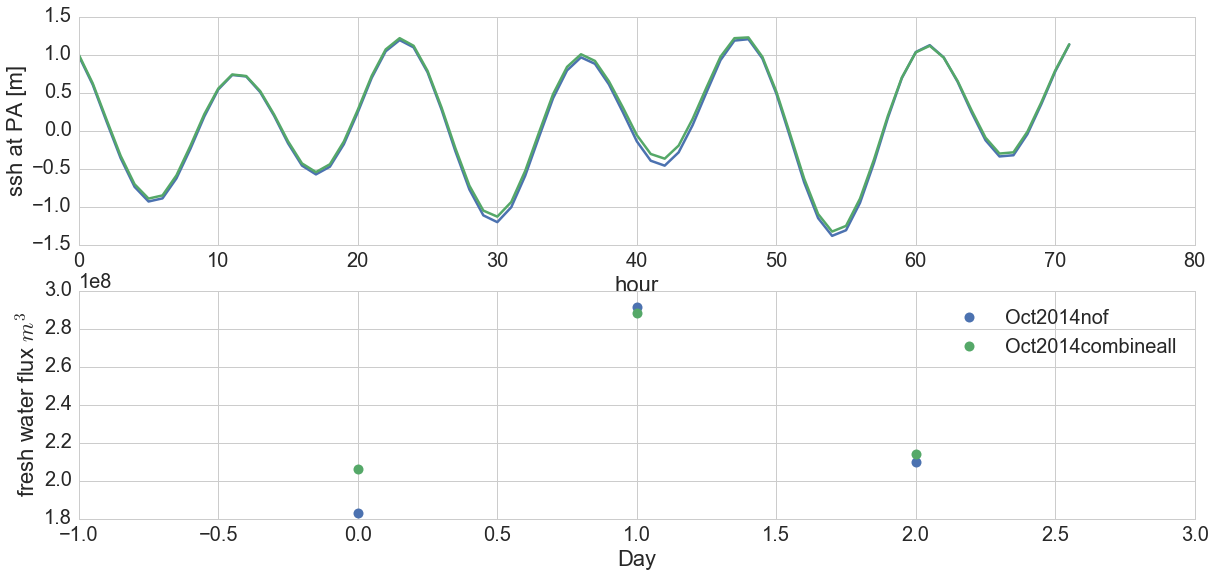

In [18]:
## strong wind October nof vs f
paths = ['Oct2014nof','Oct2014combineall']
tst = {'Oct2014nof':480,'Oct2014combineall':480}
ten = {'Oct2014nof':551,'Oct2014combineall':551}
inte_trans_oct_strong_NWfnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
inte_trans_oct_strong_NWfnof['Oct2014combineall'].sum() - inte_trans_oct_strong_NWfnof['Oct2014nof'].sum()/(3*24*3600)

In [22]:
(inte_trans_oct_strong_NWfnof['Oct2014combineall'].sum() - inte_trans_oct_strong_NWfnof['Oct2014nof'].sum())/(3*24*3600)

92.714514370911104

* May

1888.5051062841324

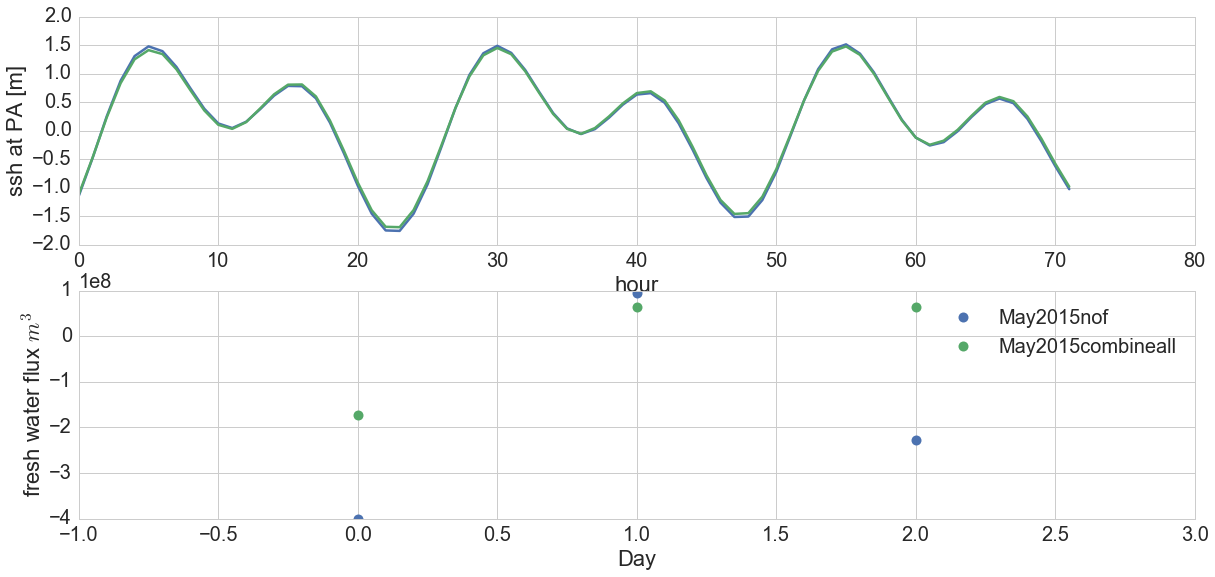

In [19]:
## weak wind May nof vs f
paths = ['May2015nof','May2015combineall']
tst = {'May2015nof':192,'May2015combineall':192}
ten = {'May2015nof':263,'May2015combineall':263}
inte_weak_May = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_weak_May['May2015combineall'].sum() - inte_weak_May['May2015nof'].sum())/(3*24*3600)

7618.1848867713688

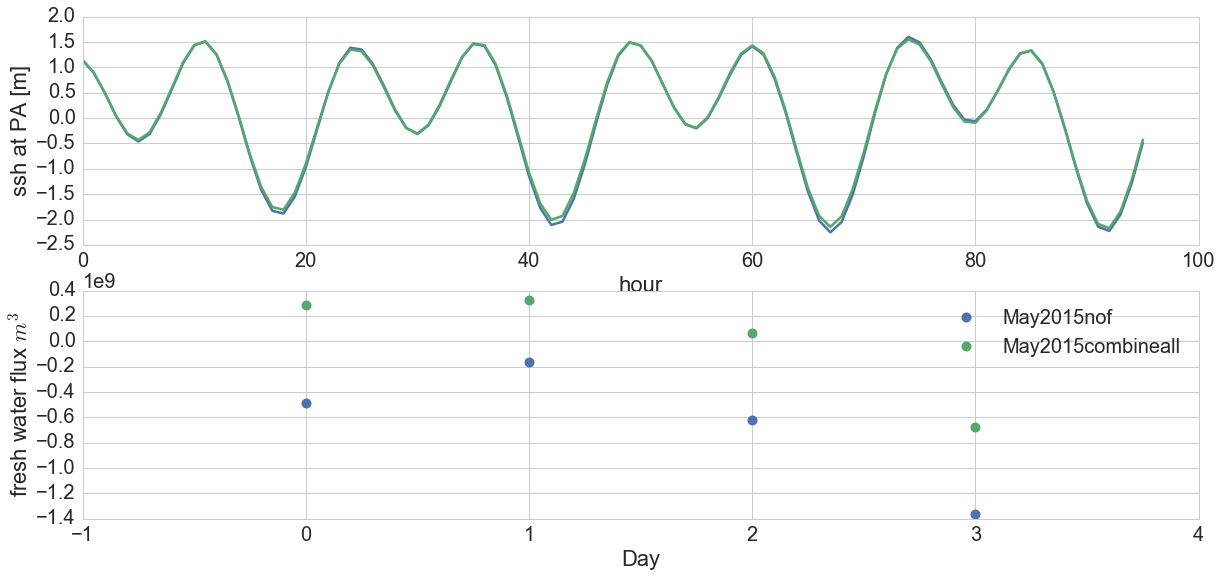

In [20]:
## moderate wind May SE nof vs f
paths = ['May2015nof','May2015combineall']
tst = {'May2015nof':360,'May2015combineall':360}
ten = {'May2015nof':455,'May2015combineall':455}
inte_may_SE_fnof = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_may_SE_fnof['May2015combineall'].sum() - inte_may_SE_fnof['May2015nof'].sum())/(24*3600*4)

5448.2956524442416

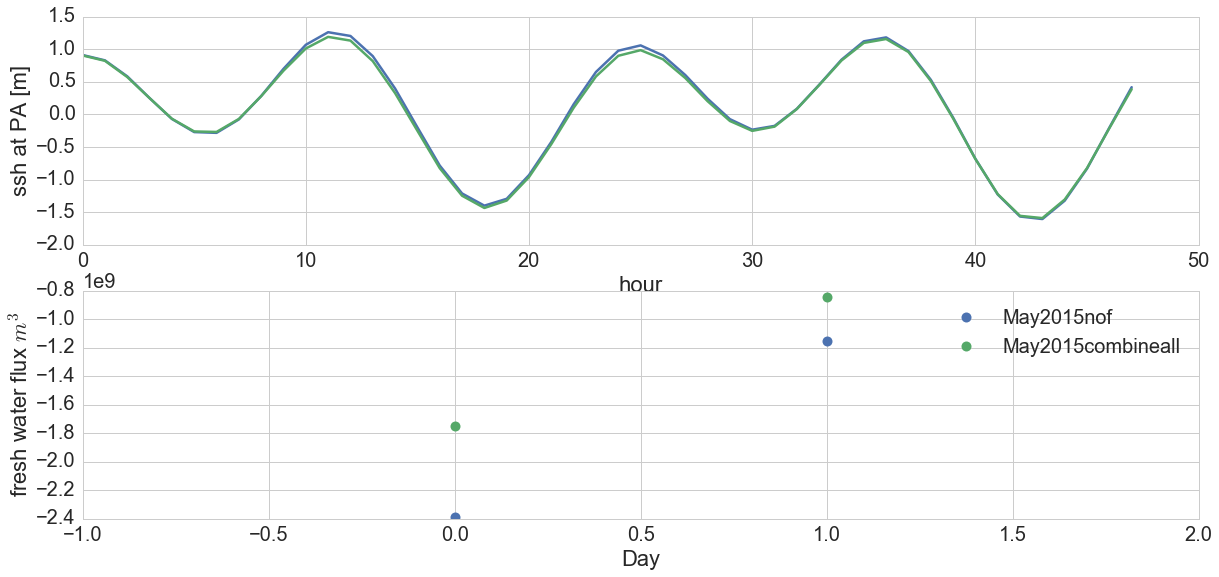

In [21]:
## strong May nof vs f
paths = ['May2015nof','May2015combineall']
tst = {'May2015nof':24,'May2015combineall':24}
ten = {'May2015nof':71,'May2015combineall':71}
inte_trans_may_strong_SEfnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans_may_strong_SEfnof['May2015combineall'].sum() - inte_trans_may_strong_SEfnof['May2015nof'].sum())/(2*24*3600)

* Overall, if the transect is longer (cross the strait), Coriolis effects in flux is weaker.